In [7]:
import joblib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from pathlib import Path
import hist 

import mplhep as hep
hep.style.use(hep.style.ATLAS)
plt.style.use(hep.style.ATLAS)

import sys
core_code_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow'
sys.path.append(core_code_path)

from core.Calculate_SF import convert_histdict2unumpy, Construct_unumpy, Map_var_title
from core.utils import HistBins, label_var, label_pt_bin

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
nominal_preds_path = "/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new/nominal"
nominal_preds_path = Path(nominal_preds_path)

plot_vars = ["jet_nTracks", "GBDT_newScore"]


In [3]:
pred_files = sorted(nominal_preds_path.rglob("pythia*_pred.pkl"))

In [4]:
read_columns = ["jet_pt", "jet_nTracks", "GBDT_newScore", "pt_idx", "target", "event_weight"]
def read_pred_file(pred_file: Path, 
                   columns: list=["jet_pt", "jet_nTracks", "GBDT_newScore", "pt_idx", "target", "event_weight"]):
    pred_pd = joblib.load(pred_file)[columns]
    return pred_pd

In [5]:
pred_pd = []
for pred_file in pred_files:
    pred_pd.append(read_pred_file(pred_file))

pred_pd = pd.concat(pred_pd)

In [6]:
pred_pd = pred_pd[pred_pd["target"]!='-']

In [7]:
joblib.dump(pred_pd,"pred_pd.pkl", compress=3)

['pred_pd.pkl']

# Figure 1 vars distribution

In [88]:
def plot_vars_vs_pt_partons(pred_pd:pd.DataFrame, 
                            pt_idxs:list=[0,2,5]):
    colors = ["black", "red", "blue"]
    assert len(colors) == len(pt_idxs)

    splitted_pd = pred_pd.groupby(["target", "pt_idx"])

    for var_idx, var in enumerate(plot_vars):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for i, pt_idx in enumerate(pt_idxs):
            gluon = splitted_pd.get_group((1, pt_idx))
            quark = splitted_pd.get_group((0, pt_idx))

            bin_contents, bin_edges = np.histogram(gluon[var], bins=HistBins[var], weights=gluon["event_weight"], 
                                                   range=[HistBins[var][0], HistBins[var][-1]])
            bin_contents = bin_contents / np.sum(bin_contents)
            max1 = np.max(bin_contents)
            ax.stairs(bin_contents, bin_edges, 
                      label=rf"Gluon, {label_pt_bin[pt_idx]}< "+r"$p_{T}$"+f" <{label_pt_bin[pt_idx+1]} GeV", 
                      color=colors[i], lw=2, ls='--')
            
            bin_contents, bin_edges = np.histogram(quark[var], bins=HistBins[var], weights=quark["event_weight"], 
                                                   range=[HistBins[var][0], HistBins[var][-1]])
            bin_contents = bin_contents / np.sum(bin_contents)
            max2 = np.max(bin_contents)
            ax.stairs(bin_contents, bin_edges, 
                      label=rf"Quark, {label_pt_bin[pt_idx]}< "+r"$p_{T}$"+f" <{label_pt_bin[pt_idx+1]} GeV", 
                      color=colors[i], lw=2)
            
        ax.set_ylabel("Normalized Entries")
        ax.set_xlabel(Map_var_title[var])

        ax.set_ylim(0, 1.5*np.max([max1, max2]))
        hep.atlas.label()
        plt.legend()
        plt.savefig(f"./plots/Parton_{var}.pdf")
    return fig, ax

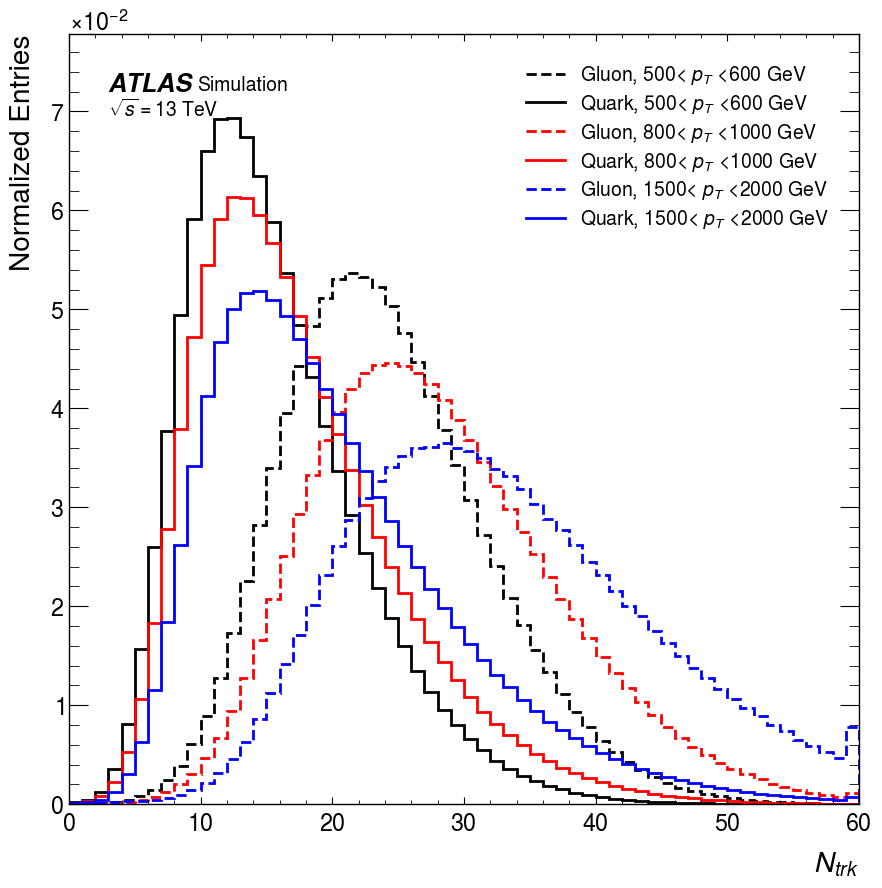

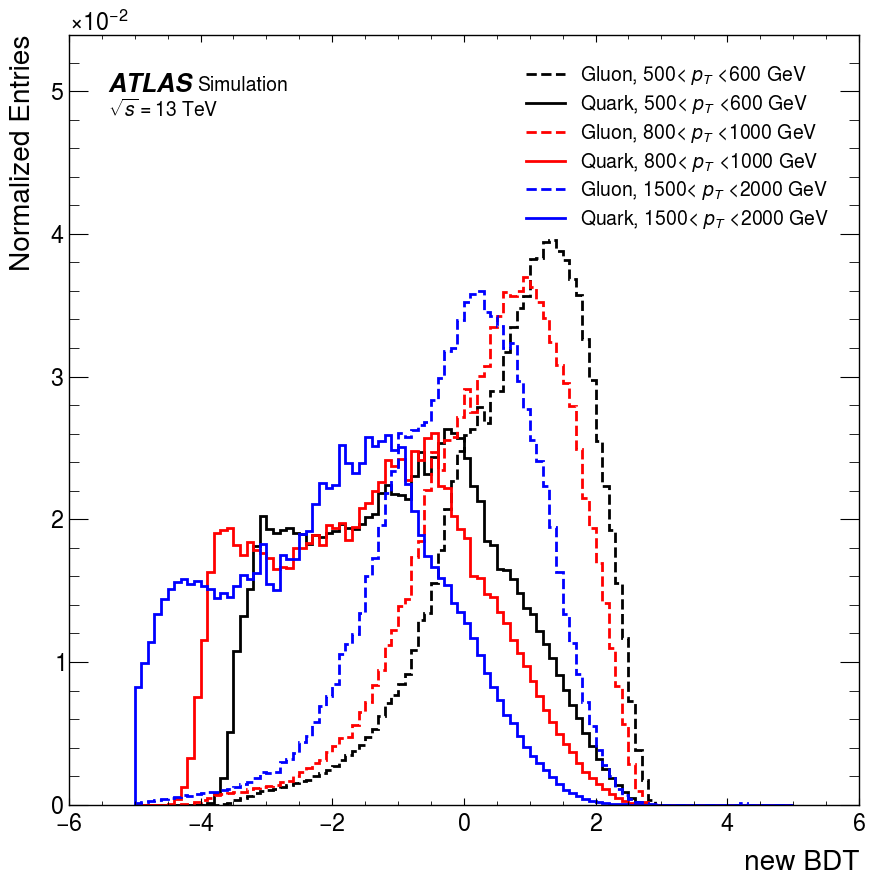

In [89]:
fig, ax = plot_vars_vs_pt_partons(pred_pd)

# Figure 2 ROC

In [3]:
pred_pd = joblib.load("pred_pd.pkl")

In [4]:
pred_pd.head()

,jet_pt,jet_nTracks,GBDT_newScore,pt_idx,target,event_weight
0,766.747925,2.0,-1.426786,1,1,17.609434
0,567.369995,34.0,1.562195,0,1,0.305107
1,517.005432,40.0,2.224734,0,1,0.305107
2,690.617371,14.0,-1.793333,1,0,0.449083
3,632.346863,15.0,-1.190105,1,0,0.449083


In [5]:
splitted_pd = pred_pd.groupby("pt_idx")
parton_pt = splitted_pd.get_group(5)

In [15]:
fpr, tpr, thresholds = roc_curve(y_true = parton_pt['target'].to_numpy(dtype=int), y_score = parton_pt['GBDT_newScore'].to_numpy())

In [16]:
roc_auc = auc(fpr, tpr)

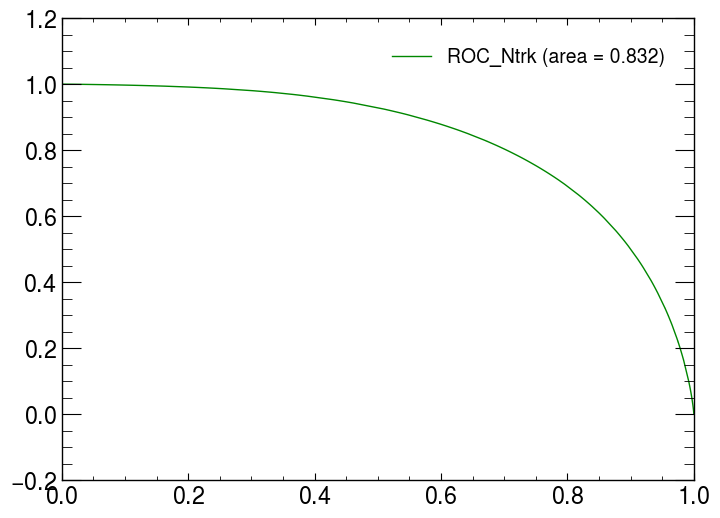

In [22]:
plt.plot(1-fpr, tpr, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc))
plt.legend()

In [8]:
parton_pt.head()

,jet_pt,jet_nTracks,GBDT_newScore,pt_idx,target,event_weight
53318,1514.553467,16.0,-1.806273,5,1,0.043380
93656,1545.118408,5.0,-3.570556,5,0,0.103662
135302,1514.113892,19.0,-1.698194,5,0,0.070203
38268,1522.469849,14.0,-2.514649,5,0,0.068005
106110,1522.415039,33.0,0.562190,5,0,0.065141


In [32]:
def plot_vars_vs_roc_partons(pred_pd:pd.DataFrame, 
                             pt_idxs:list=[0,2,5]):
    
    colors = ["black", "red", "blue"]
    assert len(colors) == len(pt_idxs)
    

    pred_pd = pred_pd.loc[pred_pd["target"] != "-"]
    splitted_pd = pred_pd.groupby("pt_idx")

    for var_idx, var in enumerate(plot_vars):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for i, pt_idx in enumerate(pt_idxs):
            parton_pt = splitted_pd.get_group(pt_idx)
            fpr, tpr, thresholds = roc_curve(y_true = parton_pt['target'].to_numpy(dtype=int), 
                                             y_score = parton_pt[var].to_numpy(),
                                             sample_weight = parton_pt['event_weight'].to_numpy())
            roc_auc = auc(fpr, tpr)
            ax.plot(1-fpr, tpr, lw=1, label=f'ROC_{label_pt_bin[pt_idx]} (area = {roc_auc:.3f})')

        ax.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])

        ax.set_ylabel("1-TPR")
        ax.set_xlabel("FPR")

        ax.set_ylim(0, 1.2)
        ax.set_title(f"ROC of {var}")
        hep.atlas.label()
        ax.legend()
        fig.savefig(f"./plots/ROC_{var}.pdf")
        
    return fig, ax

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'ROC of GBDT_newScore'}, xlabel='FPR', ylabel='1-TPR'>)

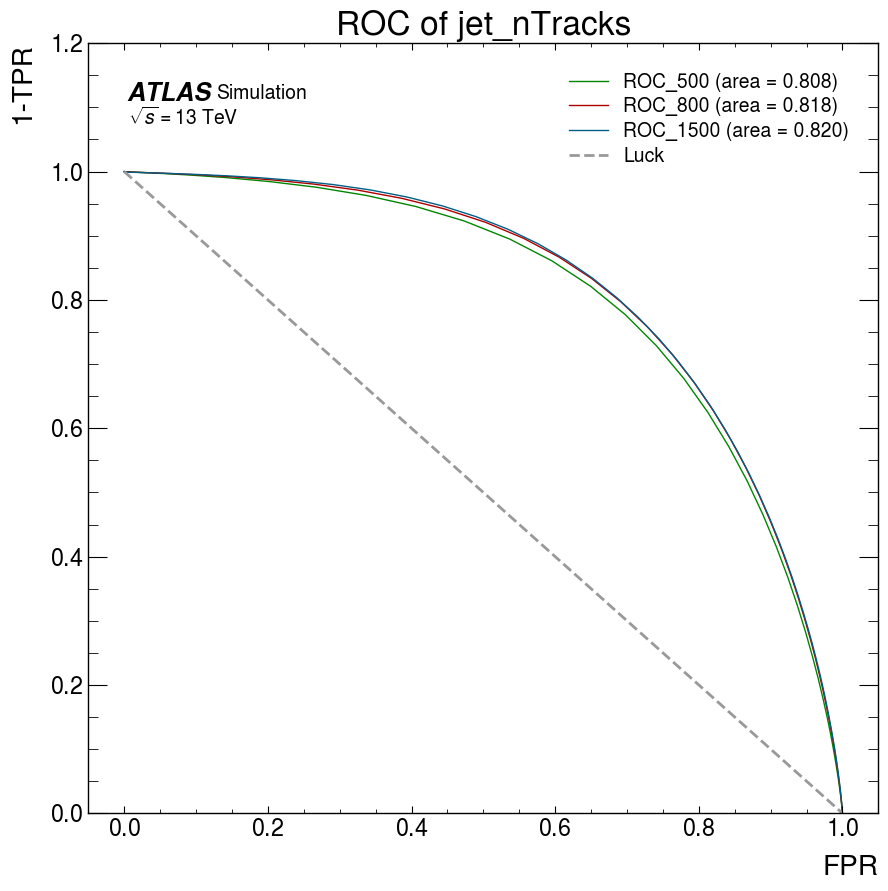

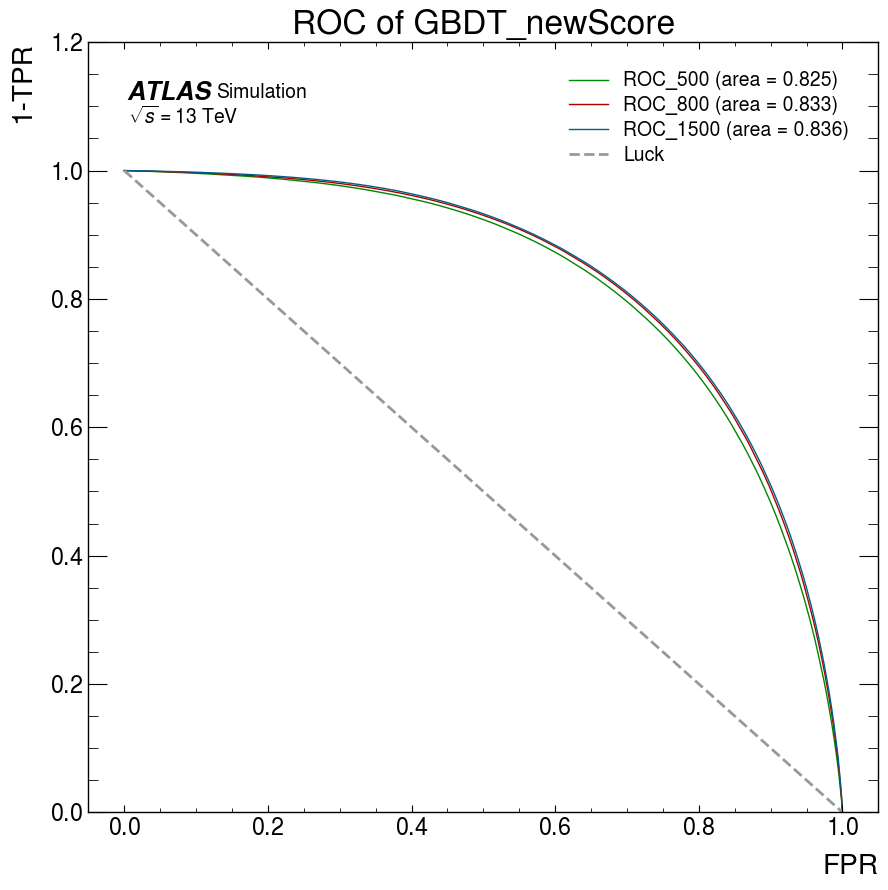

In [33]:
plot_vars_vs_roc_partons(pred_pd)